##### Import statements

In [2]:
import os
os.environ[ "TF_CPP_MIN_LOG_LEVEL"] = "3"

import warnings
warnings.simplefilter( action="ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from math import sqrt

##### Load dateset

In [3]:
series = pd.read_csv(
	filepath_or_buffer="../data/shampoo.csv",
	header=0,
	parse_dates=[ 0],
	index_col=0,
	date_parser=lambda x: datetime.strptime( f"190{ x}", "%Y-%m")
)

series.head( 5)

,Sales
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3


<Figure size 640x480 with 0 Axes>

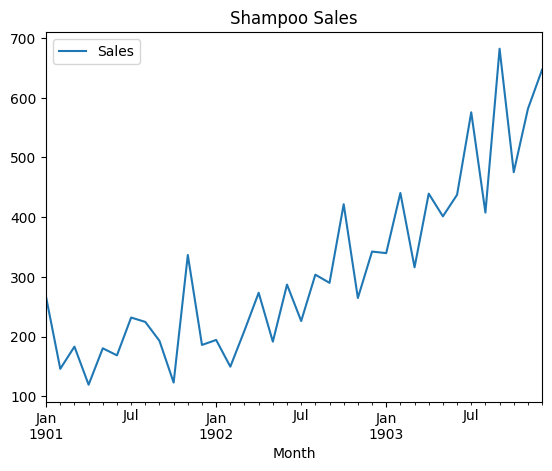

In [4]:
plt.figure()
series.plot()
plt.title( "Shampoo Sales")
plt.show()

##### Function for creating differenced series

In [5]:
def difference( dataset, interval=1):
	diff = []

	for i in range( interval, len( dataset)):
		value = dataset[ i] - dataset[ i - interval]
		diff.append( value)

	return pd.Series( diff)

##### Function to create samples and target

In [6]:
def features_and_labels( data, lag=1):
	df = pd.DataFrame( data)

	columns = [ df.shift( i) for i in range( 1, lag + 1)]

	columns.append( df)

	df = pd.concat( columns, axis=1)

	df = df.drop( [ i for i in range( lag)])

	return df


##### Function to scale data to [-1, 1]

In [7]:
def scale( train, test):
	# build and fit scaler on train set
	scaler = MinMaxScaler( feature_range=( -1, 1))
	scaler = scaler.fit( train)

	# transform train set
	train = train.reshape( train.shape[ 0], train.shape[ 1])
	train_scaled = scaler.transform( train)

	# transform test set
	test = test.reshape( test.shape[ 0], test.shape[ 1])
	test_scaled = scaler.transform( test)

	return scaler, train_scaled, test_scaled

##### Function to inverse scaling for a forcasted value

In [8]:
def invert_scale( scaler, X, yhat):
	new_row = [ x for x in X] + [ yhat]

	array = np.array( new_row)

	array = array.reshape( 1, len( array))

	inverted = scaler.inverse_transform( array)

	return inverted[ 0, -1]

##### Function for evaluating the model on a dataset

In [9]:
def evaluate( model, raw_data, scaled_dataset, scaler, batch_size):
	X = scaled_dataset[ :, 0:-1]

	# reshape
	reshaped = X.reshape( len( X), 1, 1)

	# forecast dataset
	output = model.predict( reshaped, batch_size=batch_size, verbose=0)

	predictions = []

	# invert data transform on forecast
	for i in range( len( output)):
		yhat = output[ i, 0]
		
		# invert scaling
		yhat = invert_scale( scaler, X[ i], yhat)
		
		#  invert differencing
		yhat = yhat + raw_data[ i]

		predictions.append( yhat)

	# performance measure
	rmse = sqrt( mean_squared_error( raw_data[ 1:], predictions))

	return rmse

##### Function for creating and fitting model

In [10]:
def fit_lstm( train, test, split_idx, raw, scaler, batch_size, epochs, neurons):
	X, y = train[ :, :-1], train[ :, -1]

	X = X.reshape( X.shape[ 0], 1, X.shape[ 1])

	model = Sequential( [
		LSTM( neurons, batch_input_shape=( batch_size, X.shape[ 1], X.shape[ 2]), stateful=True),
		Dense( 1)
	])

	model.compile(
		loss="mean_squared_error",
		optimizer="adam"
	)

	train_rmse = []
	test_rmse = []
	
	for _ in range( epochs):
		model.fit( X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()

		raw_train = raw[ -( len( train) + len( test) + 1):-len( test)]
		train_rmse.append( evaluate( model, raw_train, train, scaler, batch_size))
		model.reset_states()

		raw_test = raw[ -( len( test) + 1):]
		test_rmse.append( evaluate( model, raw_test, test, scaler, batch_size))
		model.reset_states()

	history = pd.DataFrame( {
		"train": train_rmse,
		"test": test_rmse
	})

	return history

##### Main function for experiment

In [11]:
def experiment( epochs, batch_size, neurons, repeats, verbose=1):
	raw_values = series.values

	diff_values = difference( raw_values, 1)

	supervised = features_and_labels( diff_values, 1)

	supervised_values = supervised.values

	# train test splot
	split_idx = 22
	train, test = supervised_values[ :split_idx], supervised_values[ split_idx:]

	scaler, train_scaled, test_scaled = scale( train, test)

	train_trimmed = train_scaled[ 2:, :]
	
	if verbose == 2:
		plt.figure()

	error_scores = []

	for i in range( repeats):
		history = fit_lstm(
			train=train_trimmed,
			test=test_scaled,
			split_idx=split_idx,
			raw=raw_values,
			scaler=scaler,
			batch_size=batch_size,
			epochs=epochs,
			neurons=neurons
		)

		if verbose == 2:
			plt.plot( history[ "train"], color="blue")
			plt.plot( history[ "test"], color="orange")

		if verbose == 1:
			print( f"{ i}: TrainRMSE={ history[ 'train'].iloc[ -1]}, TestRMSE={ history[ 'test'].iloc[ -1]}")

		error_scores.append( history[ 'test'].iloc[ -1])

	if verbose == 2:
		plt.show()

	return error_scores

##### Find Epochs

Epochs: 3
0: TrainRMSE=85.68562599101088, TestRMSE=123.96044950913299
1: TrainRMSE=91.66677639285952, TestRMSE=134.47574435504742
2: TrainRMSE=95.91320235205416, TestRMSE=141.0819050241864
3: TrainRMSE=102.20327796661844, TestRMSE=147.972913504557
4: TrainRMSE=85.20097349619249, TestRMSE=131.99305703505075
5: TrainRMSE=91.02290095002247, TestRMSE=133.9637699053898
6: TrainRMSE=88.48328258338609, TestRMSE=131.81025362543923
7: TrainRMSE=83.75756897395571, TestRMSE=124.99764996599386
8: TrainRMSE=97.84773141700909, TestRMSE=147.2817264807511
9: TrainRMSE=92.0237965893868, TestRMSE=138.47825647657697


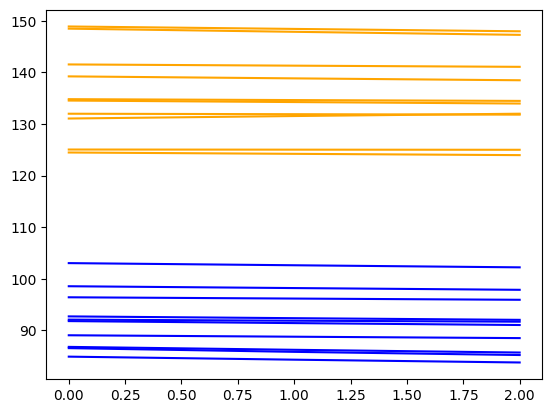

Epochs: 5
0: TrainRMSE=91.36850995017542, TestRMSE=134.1586974259669
1: TrainRMSE=86.31427139903421, TestRMSE=120.60969353397772
2: TrainRMSE=82.93802817310396, TestRMSE=134.3943253020175
3: TrainRMSE=81.15462574357898, TestRMSE=123.5445159862513
4: TrainRMSE=81.76897749775932, TestRMSE=122.76174634170879
5: TrainRMSE=98.95858562488986, TestRMSE=144.64007388110338
6: TrainRMSE=95.4003043272683, TestRMSE=138.40217622768435
7: TrainRMSE=91.3075914536977, TestRMSE=133.97182673783726
8: TrainRMSE=91.46181071839852, TestRMSE=134.44924083034311
9: TrainRMSE=85.86873476157288, TestRMSE=125.50689328571097


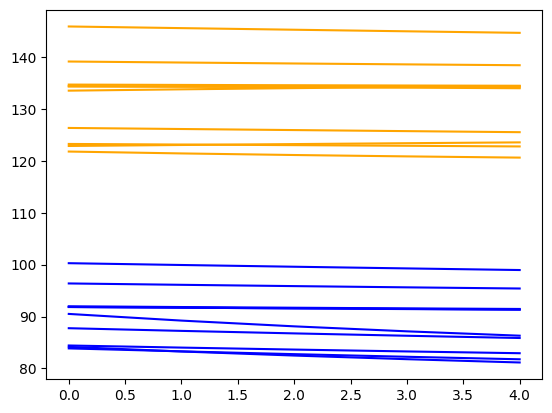

Epochs: 10
0: TrainRMSE=91.78050943457339, TestRMSE=135.28095392334902
1: TrainRMSE=87.3679990667844, TestRMSE=128.67330062691127
2: TrainRMSE=88.87821260023648, TestRMSE=133.47808026202623
3: TrainRMSE=80.98982302210933, TestRMSE=115.43305956429938
4: TrainRMSE=79.25421374778792, TestRMSE=119.18546641017659
5: TrainRMSE=83.52464432991016, TestRMSE=125.5340469854369
6: TrainRMSE=93.13255500169745, TestRMSE=138.91247076131233
7: TrainRMSE=91.68323718145264, TestRMSE=136.39126351459
8: TrainRMSE=91.39542598581572, TestRMSE=134.86038915479887
9: TrainRMSE=91.28508526743005, TestRMSE=137.20823467837815


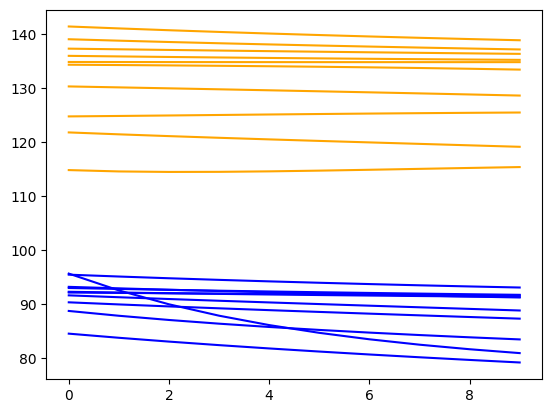

Epochs: 20
0: TrainRMSE=84.72440109011265, TestRMSE=124.26142305481918
1: TrainRMSE=93.90844742749265, TestRMSE=140.00557529352267
2: TrainRMSE=92.70234945888029, TestRMSE=137.37967263770938
3: TrainRMSE=85.0382537412469, TestRMSE=126.94689218093124
4: TrainRMSE=90.72130997875873, TestRMSE=135.04572668446622
5: TrainRMSE=91.61969313465846, TestRMSE=136.79210936920114
6: TrainRMSE=69.24450634454574, TestRMSE=112.95883121680791
7: TrainRMSE=87.67161645653914, TestRMSE=129.90928089976555
8: TrainRMSE=70.63844858066143, TestRMSE=123.56342031665925
9: TrainRMSE=77.61326782002136, TestRMSE=125.28374483644208


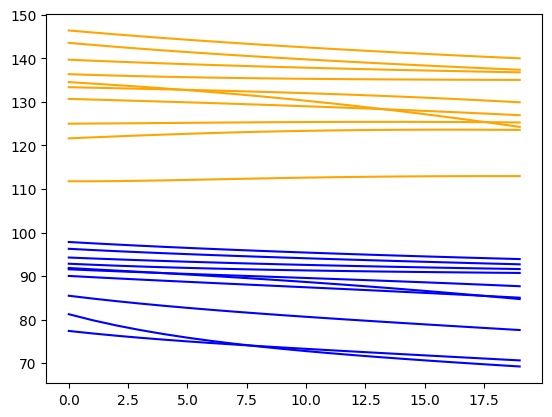

Epochs: 50
0: TrainRMSE=80.03968072553897, TestRMSE=119.21565054806435
1: TrainRMSE=68.01878534746626, TestRMSE=112.51661361811075
2: TrainRMSE=92.00996442924307, TestRMSE=136.4357267098438
3: TrainRMSE=68.43683268296762, TestRMSE=105.94882658417815
4: TrainRMSE=93.51431074667632, TestRMSE=138.1884020094048
5: TrainRMSE=87.38666773023397, TestRMSE=130.63863148311358
6: TrainRMSE=92.27176341617769, TestRMSE=136.33060541499856
7: TrainRMSE=88.42954013081552, TestRMSE=132.68493750371113
8: TrainRMSE=91.82131717015534, TestRMSE=137.48065497196907
9: TrainRMSE=75.2730620075399, TestRMSE=110.13404620501414


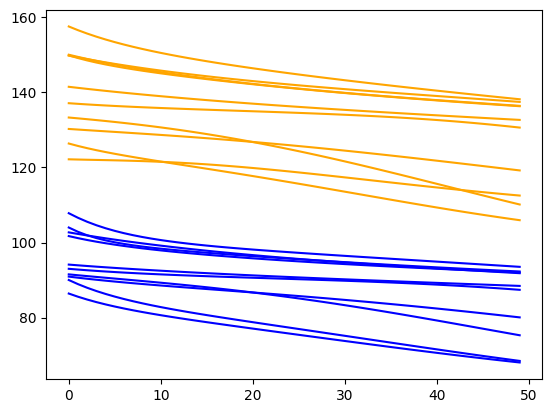

In [13]:
results = pd.DataFrame()

for e in [ 3, 5, 10, 20, 50]:
	print( f"Epochs: { e}")
	results[ str( e)] = experiment(
		epochs=e,
		batch_size=1,
		neurons=1,
		repeats=10,
		verbose=2
	)

In [14]:
results.describe()

,3,5,10,20,50
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,135.601573,131.243919,130.495727,129.214668,125.957410
std,8.213064,7.775049,8.057055,8.275337,12.665713
min,123.960450,120.609694,115.433060,112.958831,105.948827
25%,131.855954,124.035110,126.318860,124.517004,114.191373
50%,134.219757,134.065262,134.169235,128.428087,131.661784
75%,140.430993,134.435512,136.113686,136.355514,136.409446
max,147.972914,144.640074,138.912471,140.005575,138.188402


<Axes: >

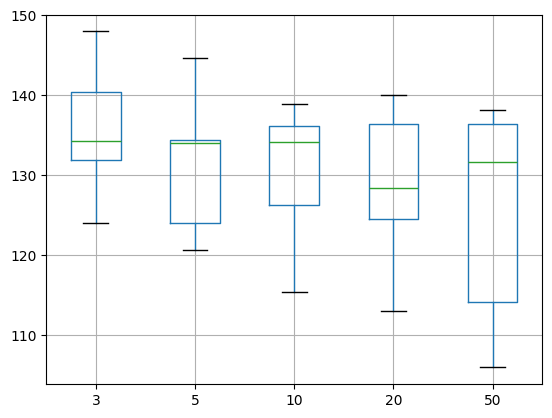

In [15]:
results.boxplot()

##### Find Batch Size

Batch Size: 1
0: TrainRMSE=85.22109176813493, TestRMSE=124.93704580434186
1: TrainRMSE=85.54151523803063, TestRMSE=128.85041067987558
2: TrainRMSE=89.9718152222835, TestRMSE=133.67507075664716
3: TrainRMSE=72.01767685989023, TestRMSE=108.11656138322586
4: TrainRMSE=69.40737682876141, TestRMSE=117.34520636125907
5: TrainRMSE=93.0857348924746, TestRMSE=138.4049319392951
6: TrainRMSE=66.17409407738786, TestRMSE=110.32215167515312
7: TrainRMSE=72.48630093799412, TestRMSE=113.8572293810377
8: TrainRMSE=93.07975315163478, TestRMSE=139.53761130433134
9: TrainRMSE=73.35766196700575, TestRMSE=118.96489265472603


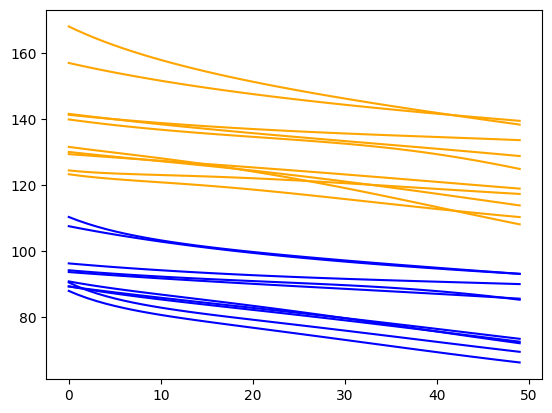

Batch Size: 2
0: TrainRMSE=82.31926540998437, TestRMSE=128.80783112997835
1: TrainRMSE=70.95116277933019, TestRMSE=127.33281773234422
2: TrainRMSE=76.52432659305406, TestRMSE=126.19520826146655
3: TrainRMSE=79.60062066756518, TestRMSE=128.51695283197571
4: TrainRMSE=92.34102609396905, TestRMSE=137.14916741801318
5: TrainRMSE=88.75460576226062, TestRMSE=133.10310732716587
6: TrainRMSE=94.74655624297165, TestRMSE=137.191747808054
7: TrainRMSE=83.01057692446548, TestRMSE=128.3281018636896
8: TrainRMSE=91.27172160813831, TestRMSE=135.94379080519835
9: TrainRMSE=75.4647407132091, TestRMSE=122.64344814680757


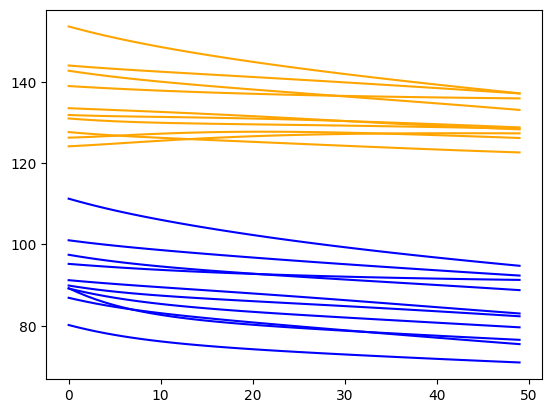

Batch Size: 4
0: TrainRMSE=88.81757811635094, TestRMSE=133.0742499977129
1: TrainRMSE=86.12195291809117, TestRMSE=130.37656390336574
2: TrainRMSE=87.29988482974919, TestRMSE=131.35677964799712
3: TrainRMSE=86.28783614422872, TestRMSE=129.89008138170783
4: TrainRMSE=98.73646697220458, TestRMSE=141.8813192756508
5: TrainRMSE=88.31043213987581, TestRMSE=133.1463859897871
6: TrainRMSE=93.0527096846455, TestRMSE=137.22703292295787
7: TrainRMSE=90.6748211011107, TestRMSE=135.95689919948143
8: TrainRMSE=95.53479963504942, TestRMSE=140.89744947556179
9: TrainRMSE=93.4345517430624, TestRMSE=139.61062596885844


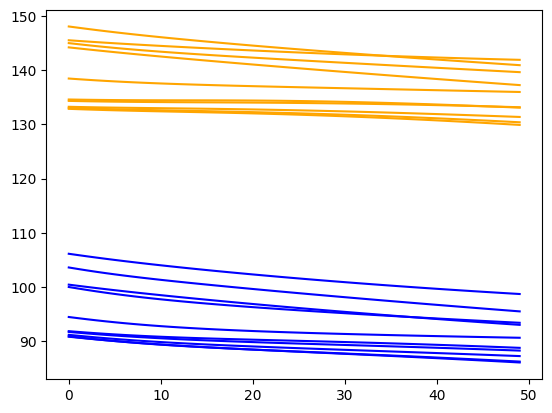

In [17]:
results = pd.DataFrame()

for b in [ 1, 2, 4]:
	print( f"Batch Size: { b}")
	results[ str( b)] = experiment(
		epochs=50,
		batch_size=b,
		neurons=1,
		repeats=10,
		verbose=2
	)

In [18]:
results.describe()

,1,2,4
count,10.000000,10.000000,10.000000
mean,123.401111,130.521217,135.341739
std,11.427189,5.024365,4.422200
min,108.116561,122.643448,129.890081
25%,114.729224,127.581639,131.786147
50%,121.950969,128.662392,134.551643
75%,132.468906,135.233620,139.014728
max,139.537611,137.191748,141.881319


<Axes: >

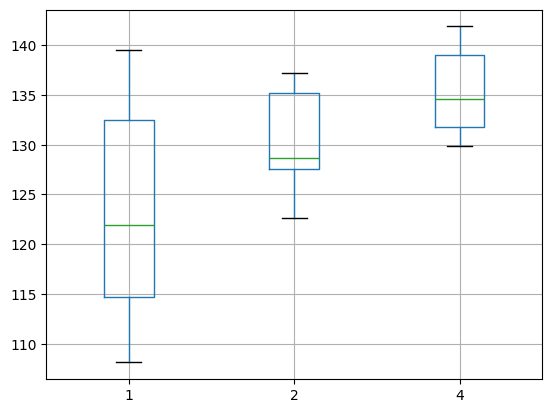

In [19]:
results.boxplot()